In [92]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import copy
import torch
from synthetic_env import synthetic_env
from naive_agents import DoNothing, FixedPhi
from scipy.optimize import curve_fit
#from dynamic_phi_agent import DynamicPhiAgent
#from dynamic_phi_agent_mean_only import DynamicPhiAgentMeanOnly
#from dynamic_phi_agent_mean_plus_var import DynamicPhiAgent

In [93]:
class expected_baseline:
        
    def __init__(self, PHI,D, kappa, nu = .99):
        self.dims=2
        self.phi = PHI
        self.D_tilde = D*(self.dims+2)*(self.dims-1)
        self.beta = 1.
        self.nu = nu
        # a useful intermediate value used in the baseline calculations
        self.block = nu + 2*PHI - self.D_tilde
        self.kappa = kappa
    
    def A(self, time_remaining):
        num = (self.beta + self.phi**2)*(1-np.exp(-time_remaining*self.block))
        denom = self.block
        return num/denom
    
    def B(self, time_remaining):
        first_term = self.dims * self.kappa * (self.beta + self.phi**2) / (self.nu*(2*self.phi-self.D_tilde))
        second_term = 1 - np.exp(-self.nu*time_remaining) - self.nu * (1-np.exp(-time_remaining*self.block))/self.block
        return first_term*second_term

    def evaluate_prescribed(self, seperation, time_remaining):
        return self.A(time_remaining)*seperation**2 + self.B(time_remaining)
    
    def evaluate_prescribed_scaled(self, seperation, time_remaining,c1,c2):
        return c1*self.A(time_remaining)*seperation**2 + c2*self.B(time_remaining)

In [119]:
def compare_return_to_baseline(phi_val, baseline, sep_size=0.2*np.pi,num_eps=50,time_horizon=50.):
    labels=["real return", "-b(r)","-b(r) fitted"]
    
    phi_agent = FixedPhi(phi_val)
    
    env = synthetic_env(sep_size)
    env.deltaT = 0.005
    env.limit = time_horizon
    step_rewards = np.zeros(int(env.limit/env.deltaT))
    baseline_pred = np.zeros(int(env.limit/env.deltaT))
    baseline_pred_fit = np.zeros(int(env.limit/env.deltaT))
    sum_distances = np.zeros(int(env.limit/env.deltaT))
    time_remaining = np.zeros(int(env.limit/env.deltaT))
    returns = np.zeros(int(env.limit/env.deltaT))
    for i in range(0,num_eps):
        time_step=0
        #episode_rew=0
        while not env.isOver():
            action=phi_agent.sample_action(env.getState())
            reward = env.step(action)
            steps_left = env.limit/env.deltaT - time_step
            step_rewards[time_step] += reward
            baseline_pred[time_step] += -baseline.evaluate_prescribed(env.dist(),env.limit-env.time)
            #baseline_pred_fit[time_step] += -baseline.evaluate_prescribed_scaled(env.dist(),env.limit-env.time, 0.49254899, 0.3539548)
            sum_distances[time_step] += env.dist()
            time_step += 1
        env.reset()
        
        
    returns = np.zeros(int(env.limit/env.deltaT))
    g_return = 0.
    for i in range(len(returns)-1,-1,-1):
        g_return = step_rewards[i] + 0.995*g_return
        returns[i] = g_return
    
    plt.plot(np.arange(len(step_rewards))/(1/env.deltaT),returns/num_eps)
    plt.plot(np.arange(len(step_rewards))/(1/env.deltaT),baseline_pred/num_eps)
    #plt.plot(np.arange(len(step_rewards))/(1/env.deltaT),baseline_pred_fit/num_eps)
    plt.legend(labels)
    plt.title(f"Baseline vs Actual Strategy {phi_val}")
    plt.xlabel("time")
    plt.ylabel("reward")
    plt.savefig(f'baseline_comparison')
    return returns/num_eps, sum_distances/num_eps, time_horizon - np.arange(0,time_horizon,env.deltaT)

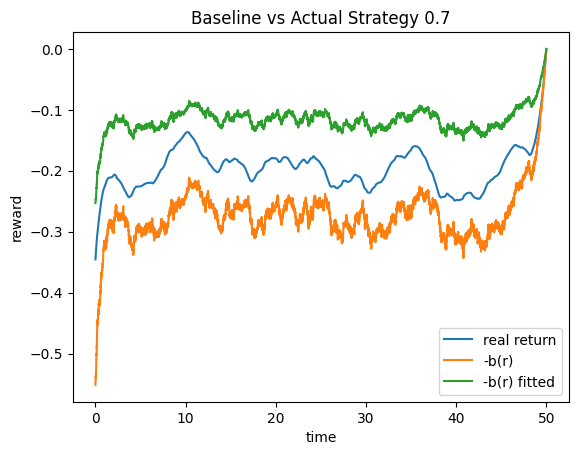

In [120]:
phi_val = 0.7
D = 0.25
#r_d = np.sqrt(0.02*np.pi/D)
kappa = 0.02*np.pi
phi_aproximator = expected_baseline(phi_val,D,kappa,nu=1.) 
avg_returns,seperation,time_left = compare_return_to_baseline(phi_val,phi_aproximator)

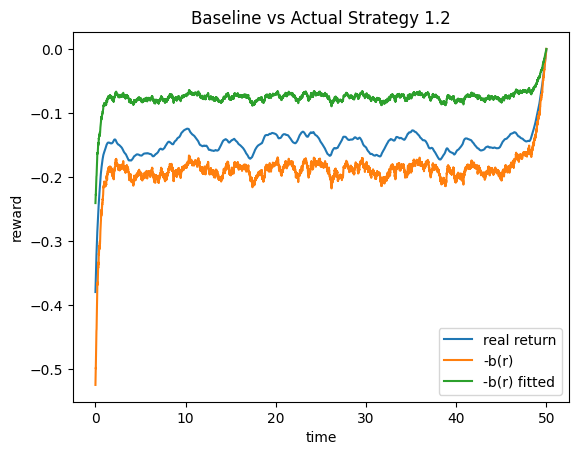

In [121]:
phi_val = 1.2
D = 0.25
#r_d = np.sqrt(0.02*np.pi/D)
kappa = 0.02*np.pi
phi_aproximator = expected_baseline(phi_val,D,kappa,nu=1.) 
avg_returns,seperation,time_left = compare_return_to_baseline(phi_val,phi_aproximator)

In [122]:
def fit(x,c1,c2):
    r = x[0,:]
    times = x[1,:]
    first_term = phi_aproximator.A(times)*r**2
    second_term = phi_aproximator.B(times)
    return (c1*first_term + c2*second_term)

In [123]:
curve_fit(fit,np.vstack((seperation[:-1],time_left[1:])),-avg_returns[:-1])

(array([0.71092916, 0.8994456 ]),
 array([[ 2.03928778e-05, -8.19657329e-06],
        [-8.19657329e-06,  3.98736465e-06]]))

In [56]:
seperation[:-1]

array([0.62486838, 0.62016086, 0.60737382, ..., 0.31800389, 0.31225744,
       0.30777817])

0.48222323


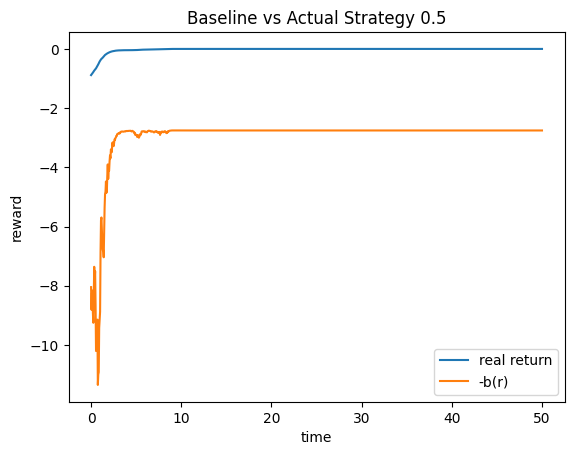

In [24]:
phi_val = 0.5
phi_aproximator = Physics_baseline(phi_val,0.25187,0.27710,3.,0.02*np.pi) 
compare_return_to_baseline(phi_val,phi_aproximator)

0.48222323


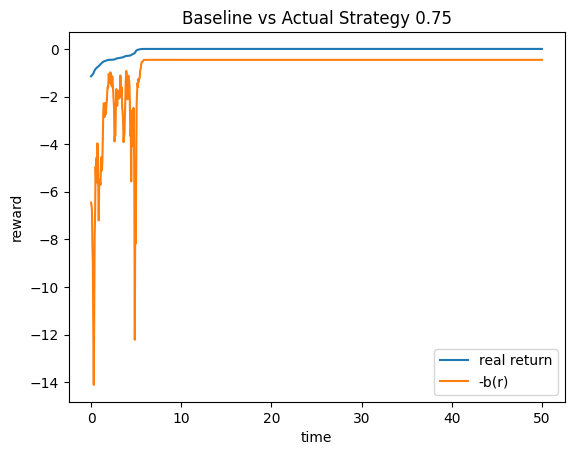

In [9]:
phi_val = 0.75
phi_aproximator = Physics_baseline(phi_val,0.25187,0.27710,3.,0.02*np.pi) 
compare_return_to_baseline(phi_val,phi_aproximator)

0.48222323


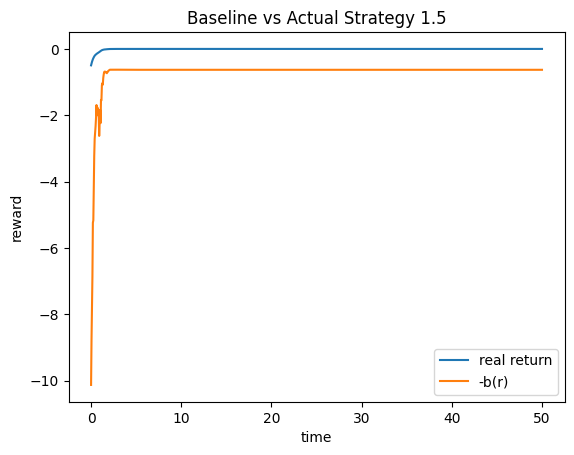

In [10]:
phi_val = 1.5
phi_aproximator = Physics_baseline(phi_val,0.25187,0.27710,3.,0.02*np.pi) 
compare_return_to_baseline(phi_val,phi_aproximator)

In [7]:
assert(1==0)

AssertionError: 

In [ ]:
for i in range(5,11):
    phi_val = i/10
    phi_aproximator = Physics_baseline(phi_val,0.25187,0.27710,5.,0.02*np.pi) 
    compare_return_to_baseline(phi_val,phi_aproximator)

In [ ]:
for i in range(5,11):
    phi_val = i/10
    print(phi_val)
    phi_agent = FixedPhi(phi_val)
    compare_return_to_baseline(phi_agent,f"phi={phi_agent.phi}",phi_aproximator)

In [ ]:
phi_val = 0.5
phi_aproximator = Physics_baseline(phi_val,0.18265,0.17904,5.) 
phi_agent = FixedPhi(1.1)
compare_return_to_baseline(phi_agent,f"phi={phi_agent.phi}",phi_aproximator)

In [ ]:
#compare_return_to_baseline(phi_agent,f"phi={phi_agent.phi}",phi_aproximator)
phi_val = 0.8
phi_aproximator = Physics_baseline(phi_val,0.16980,0.12038,10.) 
phi_agent = FixedPhi(1.0)
compare_return_to_baseline(phi_agent,"phi=1.0",phi_aproximator, time_horizon=10.)

In [ ]:
phi_aproximator.evaluate(np.array([0.02,0.018]))

In [ ]:
phi_aproximator.evaluate(0.018)

In [ ]:
x=np.array([[0.02,0.018],
        [1.,1.2]])
torch.linalg.norm(torch.tensor(x), axis=1)

In [ ]:
np.log(2.7)

In [14]:
a=np.random.random((2,2))
a

array([[0.03512617, 0.87718291],
       [0.48504639, 0.74221785]])

In [15]:
a.dot(np.array([1,0]))

array([0.03512617, 0.48504639])

In [60]:
for i in range(7,8):
    print(i)

7
